In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-hiring-assessment/Dataset/sample_submission.csv
/kaggle/input/shl-hiring-assessment/Dataset/train.csv
/kaggle/input/shl-hiring-assessment/Dataset/test.csv
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_885.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_1142.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_1006.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_817.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_765.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_508.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_257.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_330.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_72.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_328.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_858.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/

# This is my submission for the Grammar scoring engine for spoken audios project as a part of SHL assessment


**Basic procedure**



*data loading → EDA → preprocessing → feature extraction → model training → evaluation*


# 1. Data loading 

In [2]:
import pandas as pd
df = pd.read_csv('/kaggle/input/shl-hiring-assessment/Dataset/train.csv')  
print(df.head())

         filename  label
0   audio_710.wav    1.0
1  audio_1265.wav    1.0
2  audio_1114.wav    1.5
3   audio_946.wav    1.5
4  audio_1127.wav    2.0


# 2. EDA

Text(0.5, 1.0, 'Distribution of Grammar Scores')

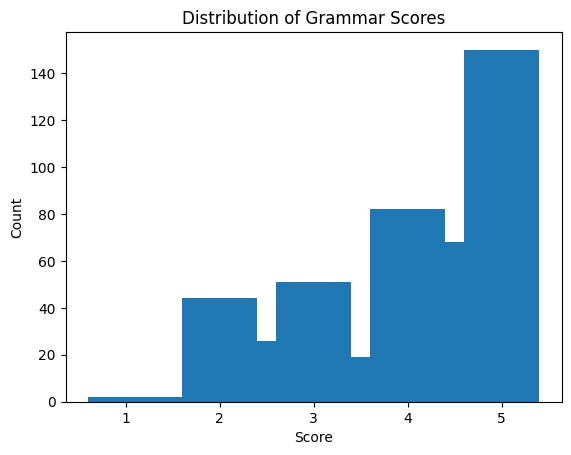

In [3]:
import matplotlib.pyplot as plt
score_counts = df['label'].value_counts().sort_index()
plt.bar(score_counts.index, score_counts.values); plt.xlabel('Score'); plt.ylabel('Count')
plt.title('Distribution of Grammar Scores')

We will use librosa here, its a python package to visualise audio related files

Text(0.5, 1.0, 'Audio Duration Distribution')

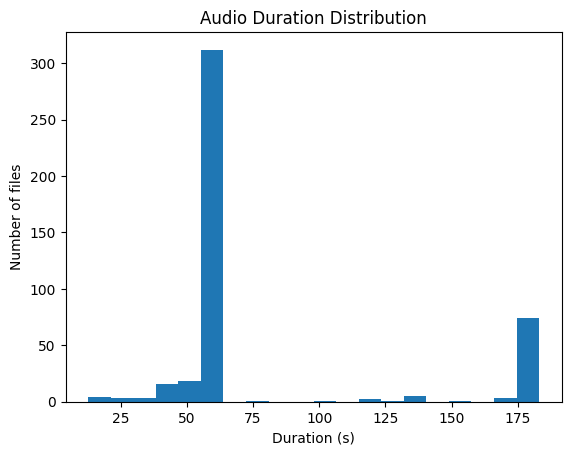

In [4]:
import librosa
durations = []
for fname in df['filename']:
    y, sr = librosa.load(f'/kaggle/input/shl-hiring-assessment/Dataset/audios/train/{fname}', sr=None)
    durations.append(len(y)/sr)
plt.hist(durations, bins=20); plt.xlabel('Duration (s)'); plt.ylabel('Number of files')
plt.title('Audio Duration Distribution')

Text(0.5, 1.0, 'Waveform of Example Audio')

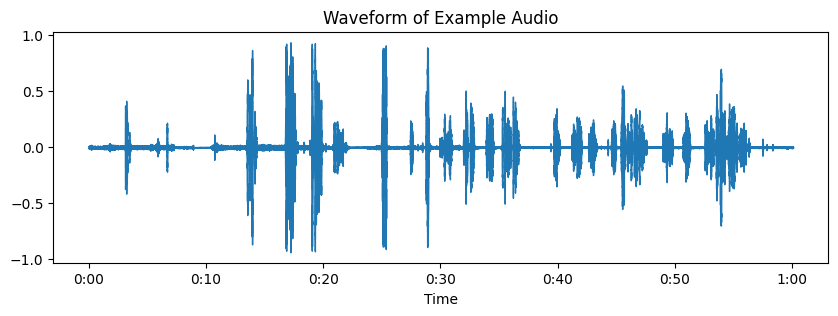

In [5]:
import numpy as np
import librosa.display
# Example: load one audio and plot waveform and spectrogram
y, sr = librosa.load('/kaggle/input/shl-hiring-assessment/Dataset/audios/train/'+df['filename'][0], sr=16000)
plt.figure(figsize=(10,3))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of Example Audio')

# 3. Preprocessing

Since I'm not so familiar with audio processing techniques, i came across stadardising the audio to same format, which is required by many pretrained models.

Before feature extraction:
* Resampling: We convert all audio to a common sample rate (16 kHz) 
* Mono conversion: Ensure mono (single channel) audio.
* Trimming/Padding: We may pad shorter clips with zeros or trim very long clips to a max length so that inputs have uniform dimensions.

In [6]:
import soundfile as sf
MAX_LEN = int(60 * 16000) 
new_y = []
for fname in df['filename']:
    audio, _ = sf.read(f'/kaggle/input/shl-hiring-assessment/Dataset/audios/train/{fname}')

    audio = librosa.resample(audio, orig_sr=_, target_sr=16000)
    if audio.ndim > 1:
        audio = librosa.to_mono(audio)

    if len(audio) < MAX_LEN:
        audio = np.pad(audio, (0, MAX_LEN - len(audio)))
    else:
        audio = audio[:MAX_LEN]
    new_y.append(audio)
X = np.stack(new_y)  # shape: (n_samples, MAX_LEN)

We can also considering removal of noise from then images, but i will take it as a learning for future work scope.

# 4. Model training

There are many ways to convert audio into text, One very popular library is 'Whisper' by OpenAI. But we will use transformer models that is free to use and that is wav2vec2 available in Huggingface

Using a pretrained model reduces overhead as it may have been trained on millions of audios itself for this espeech to text task. 

I tried to use the wav2vec2 base model itself, but the size was so large that kaggle couldnt allocate the ram to it and restarted the kernel TT
Edit- turns out even 960h that is trained on 960 hrs of audio data is bigger than 29 gb that is kaggle ram, so it wont run

Trying my luck on distilled model (seaching on huggingface), i heard this word many times since the release of deepseek r1

EDIT 2- No luck. still not working

* Googled my issue to find smaller models, then i found Hidden Unit BERT or HuBERT

Whisper for the go !! i hesitated to use it at the start because i thought openai models are not free

In [18]:
# from transformers import WhisperProcessor, WhisperForConditionalGeneration
# import torch
# import numpy as np

# # load model and processor
# processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
# model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")
# encoder = model.get_encoder() # Get the encoder part of the Whisper model

# batch_size = 32  # Adjust based on memory limits
# num_samples = len(X)

# all_embeddings = []

# for i in range(0, num_samples, batch_size):
#     batch_X = X[i:i + batch_size]
#     inputs = processor(batch_X, sampling_rate=16000, return_tensors="pt", padding=True)
#     with torch.no_grad():
#         encoder_outputs = encoder(inputs.input_features.to(encoder.device))
#         batch_embeddings = encoder_outputs.last_hidden_state.mean(dim=1).cpu().numpy()
#     all_embeddings.append(batch_embeddings) # Append the batch embeddings

# final_embeddings = np.concatenate(all_embeddings, axis=0)

# X_emb = final_embeddings # Assign the complete embeddings to X_emb
# y = df['label'].values
# X_train, X_val, y_train, y_val = train_test_split(X_emb, y, test_size=0.2, random_state=42)

# import torch.nn as nn
# import torch.optim as optim

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define device

# reg = nn.Sequential(
#     nn.Linear(X_train.shape[1], 64),  
#     nn.ReLU(),                       
#     nn.Linear(64, 32),             
#     nn.ReLU(),
#     nn.Linear(32, 1)                   
# ).to(device).float()

In [20]:
# Block 1: Feature Extraction (Whisper)
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import numpy as np

# load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")
encoder = model.get_encoder()  # Get the encoder part of the Whisper model

batch_size = 32  # Adjust based on memory limits
num_samples = len(X) 

all_embeddings = []

for i in range(0, num_samples, batch_size):
    batch_X = X[i:i + batch_size]
    inputs = processor(batch_X, sampling_rate=16000, return_tensors="pt", padding=True)
    with torch.no_grad():
        encoder_outputs = encoder(inputs.input_features.to(encoder.device))
        batch_embeddings = encoder_outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    all_embeddings.append(batch_embeddings)  # Append the batch embeddings

final_embeddings = np.concatenate(all_embeddings, axis=0)

X_emb = final_embeddings  # Assign the complete embeddings to X_emb

print("Embeddings extracted. Shape:", X_emb.shape) # Print shape for user information

Embeddings extracted. Shape: (444, 384)


In [22]:
# Block 2: Model Definition and Training
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torch

# Assuming X_emb and df are available from the previous block

y = df['label'].values
X_train, X_val, y_train, y_val = train_test_split(X_emb, y, test_size=0.2, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define device

reg = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
).to(device).float()

criterion = nn.MSELoss()
optimizer = optim.Adam(reg.parameters(), lr=1e-4)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).float()
y_val_tensor = torch.tensor(y_val, dtype=torch.float32, device=device).float()

for epoch in range(50):
    reg.train()
    preds = reg(X_train_tensor).squeeze()
    loss = torch.sqrt(criterion(preds, y_train_tensor))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate on val
    reg.eval()
    with torch.no_grad():
        val_preds = reg(X_val_tensor).squeeze()
        val_rmse = torch.sqrt(criterion(val_preds, y_val_tensor))
    print(f"Epoch {epoch}: Train RMSE={loss.item():.4f}, Val RMSE={val_rmse.item():.4f}")


Epoch 0: Train RMSE=4.2553, Val RMSE=4.1247
Epoch 1: Train RMSE=4.2478, Val RMSE=4.1174
Epoch 2: Train RMSE=4.2404, Val RMSE=4.1101
Epoch 3: Train RMSE=4.2330, Val RMSE=4.1027
Epoch 4: Train RMSE=4.2256, Val RMSE=4.0954
Epoch 5: Train RMSE=4.2183, Val RMSE=4.0882
Epoch 6: Train RMSE=4.2110, Val RMSE=4.0810
Epoch 7: Train RMSE=4.2037, Val RMSE=4.0739
Epoch 8: Train RMSE=4.1965, Val RMSE=4.0668
Epoch 9: Train RMSE=4.1893, Val RMSE=4.0597
Epoch 10: Train RMSE=4.1822, Val RMSE=4.0527
Epoch 11: Train RMSE=4.1751, Val RMSE=4.0458
Epoch 12: Train RMSE=4.1681, Val RMSE=4.0390
Epoch 13: Train RMSE=4.1612, Val RMSE=4.0323
Epoch 14: Train RMSE=4.1543, Val RMSE=4.0256
Epoch 15: Train RMSE=4.1475, Val RMSE=4.0191
Epoch 16: Train RMSE=4.1409, Val RMSE=4.0127
Epoch 17: Train RMSE=4.1343, Val RMSE=4.0064
Epoch 18: Train RMSE=4.1279, Val RMSE=4.0003
Epoch 19: Train RMSE=4.1216, Val RMSE=3.9943
Epoch 20: Train RMSE=4.1154, Val RMSE=3.9884
Epoch 21: Train RMSE=4.1092, Val RMSE=3.9825
Epoch 22: Train RMSE

Added more layers because 50 epochs were trained in one seconds

In [ ]:
# from transformers import Wav2Vec2FeatureExtractor, HubertModel
# import torch
# import numpy as np

# processor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
# model = HubertModel.from_pretrained("facebook/hubert-base-ls960")

# batch_size = 32  # Adjust based on memory limits
# num_samples = len(X)
# all_embeddings = []

# for i in range(0, num_samples, batch_size):
#     batch_X = X[i:i + batch_size]
#     inputs = processor(batch_X, sampling_rate=16000, return_tensors="pt", padding=True)
#     with torch.no_grad():
#         outputs = model(inputs.input_values.to(model.device))  
#     embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  
#     all_embeddings.append(embeddings)

# final_embeddings = np.concatenate(all_embeddings, axis=0)

# print(f"Shape of final embeddings: {final_embeddings.shape}")


# from transformers import Wav2Vec2Processor, Wav2Vec2Model
# import torch
# from transformers import Wav2Vec2Processor, Wav2Vec2Model

# processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
# model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

# # Extract features (batch inference)
# inputs = processor(X, sampling_rate=16000, return_tensors="pt", padding=True)
# with torch.no_grad():
#     outputs = model(inputs.input_values)  # last_hidden_state: [batch, time, dim]
# embeddings = outputs.last_hidden_state.mean(dim=1)  # mean-pool over time -> [batch, dim]
# # Extract features (batch inference)
# inputs = processor(X, sampling_rate=16000, return_tensors="pt", padding=True)
# with torch.no_grad():
#     outputs = model(inputs.input_values) 
# embeddings = outputs.last_hidden_state.mean(dim=1) 

Using a very simple neural network with just 1 layer and mean squared error as criterion

In [12]:
# from sklearn.model_selection import train_test_split
# X_emb = embeddings
# y = df['label'].values
# X_train, X_val, y_train, y_val = train_test_split(X_emb, y, test_size=0.2, random_state=42)

# import torch.nn as nn
# import torch.optim as optim

# reg = nn.Sequential(
#     nn.Linear(X_emb.shape[1], 1)
# ).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(reg.parameters(), lr=1e-4)

ValueError: Found input variables with inconsistent numbers of samples: [28, 444]

In [29]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).float()  # Ensure y_train is float32
y_val_tensor = torch.tensor(y_val, dtype=torch.float32, device=device).float()    # Ensure y_val is float32

train_losses = []  # To store training losses
val_losses = [] 

# Training loop
for epoch in range(200):
    reg.train()
    preds = reg(X_train_tensor).squeeze()
    loss = torch.sqrt(criterion(preds, y_train_tensor))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate on val
    reg.eval()
    with torch.no_grad():
        val_preds = reg(X_val_tensor).squeeze()
        val_rmse = torch.sqrt(criterion(val_preds, y_val_tensor))
    train_losses.append(loss.item())  # Append to the list
    val_losses.append(val_rmse.item())  # Append to the list
    print(f"Epoch {epoch}: Train RMSE={loss.item():.4f}, Val RMSE={val_rmse.item():.4f}")
    

Epoch 0: Train RMSE=0.8252, Val RMSE=0.9938
Epoch 1: Train RMSE=0.8243, Val RMSE=0.9926
Epoch 2: Train RMSE=0.8233, Val RMSE=0.9915
Epoch 3: Train RMSE=0.8223, Val RMSE=0.9904
Epoch 4: Train RMSE=0.8213, Val RMSE=0.9893
Epoch 5: Train RMSE=0.8203, Val RMSE=0.9881
Epoch 6: Train RMSE=0.8194, Val RMSE=0.9870
Epoch 7: Train RMSE=0.8184, Val RMSE=0.9859
Epoch 8: Train RMSE=0.8174, Val RMSE=0.9848
Epoch 9: Train RMSE=0.8165, Val RMSE=0.9837
Epoch 10: Train RMSE=0.8155, Val RMSE=0.9826
Epoch 11: Train RMSE=0.8146, Val RMSE=0.9815
Epoch 12: Train RMSE=0.8136, Val RMSE=0.9804
Epoch 13: Train RMSE=0.8127, Val RMSE=0.9794
Epoch 14: Train RMSE=0.8117, Val RMSE=0.9783
Epoch 15: Train RMSE=0.8108, Val RMSE=0.9772
Epoch 16: Train RMSE=0.8098, Val RMSE=0.9762
Epoch 17: Train RMSE=0.8089, Val RMSE=0.9751
Epoch 18: Train RMSE=0.8080, Val RMSE=0.9740
Epoch 19: Train RMSE=0.8070, Val RMSE=0.9730
Epoch 20: Train RMSE=0.8061, Val RMSE=0.9719
Epoch 21: Train RMSE=0.8052, Val RMSE=0.9709
Epoch 22: Train RMSE

Graphs n ol to see training quality

# 5. Evaluation

Text(0.5, 1.0, 'Training and Validation RMSE')

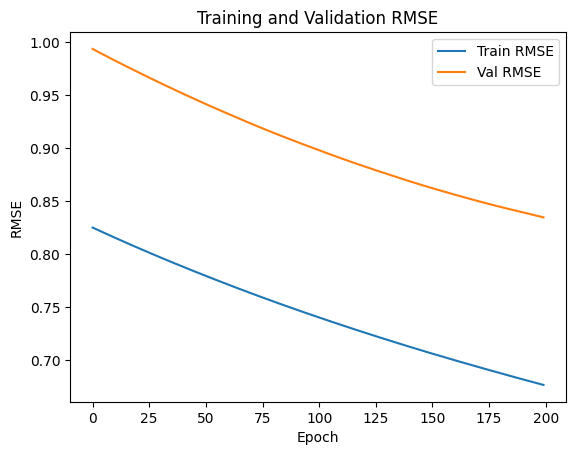

In [30]:
plt.plot(train_losses, label='Train RMSE')
plt.plot(val_losses, label='Val RMSE')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('RMSE'); plt.title('Training and Validation RMSE')


**ITS REDUCINGGGGG!!!!
Validation loss being consistenly higher than train loss shows no overfitting or underfitting**


# Storing

In [34]:
import pandas as pd
import torch
import numpy as np
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Load test data
test_df = pd.read_csv('/kaggle/input/shl-hiring-assessment/Dataset/sample_submission.csv')

# 1. Feature Extraction for Test Data (Similar to training)
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")
encoder = model.get_encoder()  # Get the encoder

batch_size = 32
test_audio_paths = ['/kaggle/input/shl-hiring-assessment/Dataset/audios/test/' + fname for fname in test_df['filename']] #create path

test_embeddings = []
MAX_LEN = int(60 * 16000)

for i in range(0, len(test_audio_paths), batch_size):
    batch_audio_paths = test_audio_paths[i:i + batch_size]
    batch_audio = []
    for audio_path in batch_audio_paths:
        audio, _ = sf.read(audio_path)
        audio = librosa.resample(audio, orig_sr=_, target_sr=16000)
        if audio.ndim > 1:
            audio = librosa.to_mono(audio)
        if len(audio) < MAX_LEN:
            audio = np.pad(audio, (0, MAX_LEN - len(audio)))
        else:
            audio = audio[:MAX_LEN]
        batch_audio.append(audio)

    batch_X = np.stack(batch_audio)
    inputs = processor(batch_X, sampling_rate=16000, return_tensors="pt", padding=True)

    with torch.no_grad():
        encoder_outputs = encoder(inputs.input_features.to(encoder.device))
        batch_test_embeddings = encoder_outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    test_embeddings.extend(batch_test_embeddings)

test_embeddings = np.array(test_embeddings) # Convert to numpy array

# 2. Prediction on Test Embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reg.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_preds = reg(torch.tensor(test_embeddings, dtype=torch.float32, device=device)).cpu().numpy().squeeze()

# 3. Create Submission File
test_df['label'] = test_preds
test_df.to_csv('/kaggle/working/submission.csv', index=False)  # Save to /kaggle/working/
print("Submission file saved to /kaggle/working/submission.csv")


Submission file saved to /kaggle/working/submission.csv


**Note- Could use whisper medium or large fro better accuracies**